In [1]:
import os
from pathlib import Path
import pickle
from collections import defaultdict
from itertools import product

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from tqdm.auto import tqdm

import torch
import torch.nn as nn

from deep_ei import topology_of, vector_ei_of_layer

In [14]:
# matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# matplotlib.rc('text', usetex=True)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
dtype = torch.float32
torch.set_default_dtype(dtype)
print(f"Using {device} device")

Using cuda device


In [3]:
def blueMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("Blues")
    return colormap(0.85 * pos / size + 0.15) # avoid using the lightest blue color -- it's not visible

## Let's save all the data first, so that figure tweaking takes less time

In [5]:
database = {
    "AB": {},
    "ABC": {}
}

### A -> B network data

In [6]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

bins = [8, 16, 32, 64]
activations = {
    "Sigmoid": {
        "fn": nn.Sigmoid(),
        "range": (0, 1)
    },
    "Tanh": {
        "fn": nn.Tanh(),
        "range": (-1, 1)
    },
    "ReLU": {
        "fn": nn.ReLU(),
        "range": (0, 1)
    }
}

ws = np.arange(0, 27, 0.05)
t = tqdm(total=len(activations) * len(bins) * len(ws))
for a in activations:
    database['AB'][a] = {}
    for b in bins:
        eis = []
        for w in ws:
            singleton.weight.data[0][0] = w
            eis.append(vector_ei_of_layer(singleton, top, 
                                   samples=30000, 
                                   batch_size=1000,  
                                   in_range=activations[a]['range'],
                                   in_bins=b,
                                   out_range=activations[a]['range'], 
                                   out_bins=b,
                                   activation=activations[a]['fn'], 
                                   device=device))
            t.update()
        database['AB'][a][b] = {}
        database['AB'][a][b]['ws'] = ws
        database['AB'][a][b]['EIs'] = eis

### A, B -> C network data

In [7]:
tiny_network = nn.Linear(2, 1, bias=False).to(device)
top = topology_of(tiny_network, input=torch.zeros(1, 2).to(device))

evalPoints = 100
lbound, ubound = -10.0, 10.0
stepSize = (ubound - lbound) / evalPoints

x = y = np.arange(lbound, ubound, stepSize)
X, Y = np.meshgrid(x, y)
rX,rY = np.ravel(X), np.ravel(Y)

t = tqdm(total=len(activations) * evalPoints * evalPoints)
for a in activations:
    database['ABC'][a] = {}
    b = 64
    eis = []
    for i in range(evalPoints * evalPoints):
        wA, wB = rX[i], rY[i]
        weights = torch.tensor([[wA, wB]]).to(device)
        tiny_network.weight.data = weights
        EI = vector_ei_of_layer(tiny_network, top, 
                         samples=100000, 
                         batch_size=1000, 
                         in_range=activations[a]['range'],
                         in_bins=b,
                         out_range=activations[a]['range'],
                         out_bins=b,
                         activation=activations[a]['fn'], device=device)
        eis.append(EI)
        t.update()
    zs = np.array(eis)
    Z = zs.reshape(X.shape)
    database['ABC'][a][b] = {}
    database['ABC'][a][b]['ws'] = ws
    database['ABC'][a][b]['X'] = X
    database['ABC'][a][b]['Y'] = Y
    database['ABC'][a][b]['EIs'] = Z

In [8]:
with open('ei-whole-toy-network-database.pkl', 'wb') as f:
    pickle.dump(database, f)

In [4]:
with open('ei-whole-toy-network-database.pkl', 'rb') as f:
    database = pickle.load(f)

In [6]:
bins = [8, 16, 32, 64]
activations = {
    "Sigmoid": {
        "fn": nn.Sigmoid(),
        "range": (0, 1)
    },
    "Tanh": {
        "fn": nn.Tanh(),
        "range": (-1, 1)
    },
    "ReLU": {
        "fn": nn.ReLU(),
        "range": (0, 1)
    }
}

In [8]:
evalPoints = 100
lbound, ubound = -10.0, 10.0
stepSize = (ubound - lbound) / evalPoints

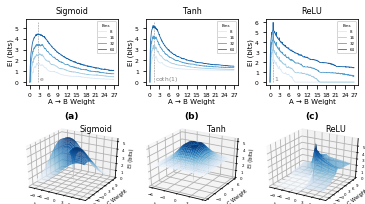

In [34]:
plt.figure(figsize=(5.5, 3.2))

ilabel = {
    'row1': {
        0: '(a)',
        1: '(b)',
        2: '(c)'
    },
    'row2': {
        0: '(d)',
        1: '(e)',
        2: '(f)'
    }
}

for i, a in enumerate(activations):
    ax = plt.subplot(2, 3, i+1)
    
    if a == 'Sigmoid':
        ax.plot((np.e, np.e), (0, 5.5), '--', color='grey', linewidth=0.5)
        ax.text(np.e + 0.3, 0.2, "e", fontsize=6, color='grey')
        
    if a == 'Tanh':
        coth1 = 1 / np.tanh(1)
        ax.plot((coth1, coth1), (0, 5.5), '--', color='grey', linewidth=0.5)
        ax.text(coth1 + 0.3, 0.2, "$\coth(1)$", fontsize=6, color='grey')
        
    if a == 'ReLU':
        ax.plot((1, 1), (0, 5.5), '--', color='grey', linewidth=0.5)
        ax.text(1 + 0.3, 0.2, "1", fontsize=6, color='grey')
    
    for b in bins:
        color = blueMap(bins, b)
        ws = database['AB'][a][b]['ws']
        EIs = database['AB'][a][b]['EIs']
        ax.plot(ws, EIs, color=color, label=str(b), linewidth=0.8)
        ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1.0))
        ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
        ax.tick_params(axis='both', which='major', labelsize=6)
        

    ax.set_xlabel('A → B Weight', fontsize=7)
    ax.xaxis.labelpad = 1
    ax.set_ylabel("EI (bits)",fontsize=7)
    ax.yaxis.labelpad = 1
    ax.set_title(a, fontsize=8)
    lg = ax.legend(title="Bins", prop={'size': 4})
    lg.get_title().set_fontsize(4)
    
    ax.text(0.5, -0.5, ilabel['row1'][i], size=9, ha="center", weight="bold", 
         transform=ax.transAxes)
    
for i, a in enumerate(activations):
    ax = plt.subplot(2, 3, 3 + i+1, projection='3d')

    X = database['ABC'][a][64]['X']
    Y = database['ABC'][a][64]['Y']
    Z = database['ABC'][a][64]['EIs']
    
    if i == 1:
        X = X[20:-20, 20:-20]
        Y = Y[20:-20, 20:-20]
        Z = Z[20:-20, 20:-20]
    
    ax.plot_surface(X, Y, Z, cmap=plt.cm.Blues)

    size = ubound - lbound
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
    ax.tick_params(axis='both',which='major', labelsize=4, pad=-5)

    ax.set_title(a, fontsize=8, x=0.76, y=0.98)
    ax.set_xlabel('A → C Weight', fontsize=5)
    ax.set_ylabel('B → C Weight', fontsize=5)
    ax.set_zlabel("EI (bits)", fontsize=5)
    ax.xaxis.labelpad = -12
    ax.yaxis.labelpad = -12
    ax.zaxis.labelpad = -14
    ax.dist = 8
    
    if i == 0:
        ax.text(0, 0, -6.35, ilabel['row2'][i], size=9, ha="center", weight="bold")
    elif i == 1:
        ax.text(0, 0, -6.5, ilabel['row2'][i], size=9, ha="center", weight="bold")
    elif i == 2:
        ax.text(0, 0, -7.35, ilabel['row2'][i], size=9, ha="center", weight="bold")
    
plt.subplots_adjust(hspace=0.7, wspace=0.3, top=0.92, bottom=0.15, left=0.08, right=0.92)
# plt.tight_layout()
plt.savefig('figures/ei-whole-toy-network.pdf', dpi=100)
